El objetivo de este análisis es explorar y modelar los factores asociados a la depresión en estudiantes,
utilizando un conjunto de datos que incluye variables demográficas, académicas, sociales y de estilo de vida.
Se busca identificar patrones, relaciones y posibles predictores que permitan comprender mejor el bienestar mental estudiantil,
así como construir modelos de clasificación para predecir el riesgo de depresión.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

print("Path to dataset files:", path)

100%|██████████| 456k/456k [00:00<00:00, 1.11MB/s]

Extracting files...
Path to dataset files: /home/johi/.cache/kagglehub/datasets/adilshamim8/student-depression-dataset/versions/1


In [6]:
# Instalar librerías si no están instaladas
%pip install scipy scikit-learn plotly

# Importar librerías estándar
import re
import math
import os
import warnings

# Importar librerías para manipulación de datos y análisis
import numpy as np
import pandas as pd
import scipy.stats as stats

# Importar librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Importar librerías de Kaggle para manejo de datos
import kagglehub

# Importar librerías de Scikit-learn para machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score

# Configurar el entorno de visualización y advertencias
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Descarga el dataset a una carpeta local y nos da la ruta
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

# Construye la ruta completa al archivo CSV
full_csv_path = os.path.join(path, os.listdir(path)[0])

# Carga el archivo CSV usando la ruta local
data = pd.read_csv(full_csv_path)

# Muestra las primeras filas para confirmar la carga
print("Datos cargados en un entorno local:")
data.head()

Datos cargados en un entorno local:


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


Limpieza de datos

In [38]:
# Ver el contenido de la dataset e identificar qué debo limpiar
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   id                                     27901 non-null  int64   
 1   Gender                                 27901 non-null  category
 2   Age                                    27901 non-null  float64 
 3   City                                   27901 non-null  category
 4   Profession                             27901 non-null  category
 5   Academic Pressure                      27901 non-null  float64 
 6   Work Pressure                          27901 non-null  float64 
 7   CGPA                                   27901 non-null  float64 
 8   Study Satisfaction                     27901 non-null  float64 
 9   Job Satisfaction                       27901 non-null  float64 
 10  Sleep Duration                         27883 non-null  cat

In [34]:
#Convertir columnas a Category
data['Gender'] = data['Gender'].astype('category')
data['City'] = data['City'].astype('category')
data['Sleep Duration'] = data['Sleep Duration'].astype('category')
data['Dietary Habits'] = data['Dietary Habits'].astype('category')
data['Degree'] = data['Degree'].astype('category')
data['Have you ever had suicidal thoughts ?'] = data['Have you ever had suicidal thoughts ?'].astype('category')
data['Family History of Mental Illness'] = data['Family History of Mental Illness'].astype('category')
data['Depression'] = data['Depression'].astype('category')

In [ ]:
# Verificar los tipos de datos después de la conversión
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   id                                     27901 non-null  int64   
 1   Gender                                 27901 non-null  category
 2   Age                                    27901 non-null  float64 
 3   City                                   27901 non-null  category
 4   Profession                             27901 non-null  category
 5   Academic Pressure                      27901 non-null  float64 
 6   Work Pressure                          27901 non-null  float64 
 7   CGPA                                   27901 non-null  float64 
 8   Study Satisfaction                     27901 non-null  float64 
 9   Job Satisfaction                       27901 non-null  float64 
 10  Sleep Duration                         27883 non-null  cat

In [37]:
# Estadísticas descriptivas
data.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000


In [36]:
# Dimensiones del dataset
data.shape

(27901, 18)

Análisis Univariable

In [13]:
# Estadísticas de resumen para variables numéricas
print(data[['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Work/Study Hours']].describe())

# Distribución de frecuencia de variables categóricas
for column in ['Gender', 'Depression', 'Sleep Duration', 'Dietary Habits', 'Family History of Mental Illness']:
    print(f"\nDistribución de frecuencia de: {column}")
    print(data[column].value_counts())
    print("-" * 30)

                Age  Academic Pressure  Work Pressure          CGPA  \
count  27901.000000       27901.000000   27901.000000  27901.000000   
mean      25.822300           3.141214       0.000430      7.656104   
std        4.905687           1.381465       0.043992      1.470707   
min       18.000000           0.000000       0.000000      0.000000   
25%       21.000000           2.000000       0.000000      6.290000   
50%       25.000000           3.000000       0.000000      7.770000   
75%       30.000000           4.000000       0.000000      8.920000   
max       59.000000           5.000000       5.000000     10.000000   

       Work/Study Hours  
count      27901.000000  
mean           7.156984  
std            3.707642  
min            0.000000  
25%            4.000000  
50%            8.000000  
75%           10.000000  
max           12.000000  

Distribución de frecuencia de: Gender
Gender
Male      15547
Female    12354
Name: count, dtype: int64
----------------------

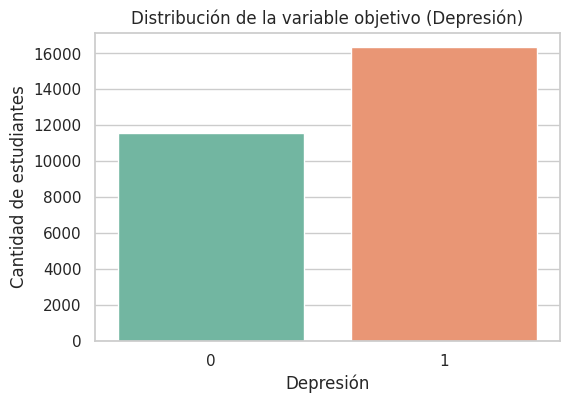

In [14]:
#Distribución de la variable objetivo
plt.figure(figsize=(6,4))
sns.countplot(x='Depression', data=data, palette='Set2')
plt.title('Distribución de la variable objetivo (Depresión)')
plt.xlabel('Depresión')
plt.ylabel('Cantidad de estudiantes')
plt.show()  

El gráfico de distribución de la variable objetivo (Depresión) muestra la cantidad de estudiantes que presentan o no depresión.
Se observa el balance entre ambas clases, lo que permite identificar si el dataset está equilibrado o existe desbalance, aspecto importante para el análisis y la construcción de modelos predictivos.

Análisis Multivariable

El análisis multivariable tiene como objetivo explorar las relaciones simultáneas entre múltiples variables del conjunto de datos, para identificar cómo interactúan y cuáles son los factores que, en conjunto, se asocian con la depresión en estudiantes. Este enfoque permite detectar patrones complejos, evaluar la influencia relativa de diferentes variables y construir modelos predictivos más precisos, considerando la interacción entre factores demográficos, académicos, sociales y de estilo de vida.

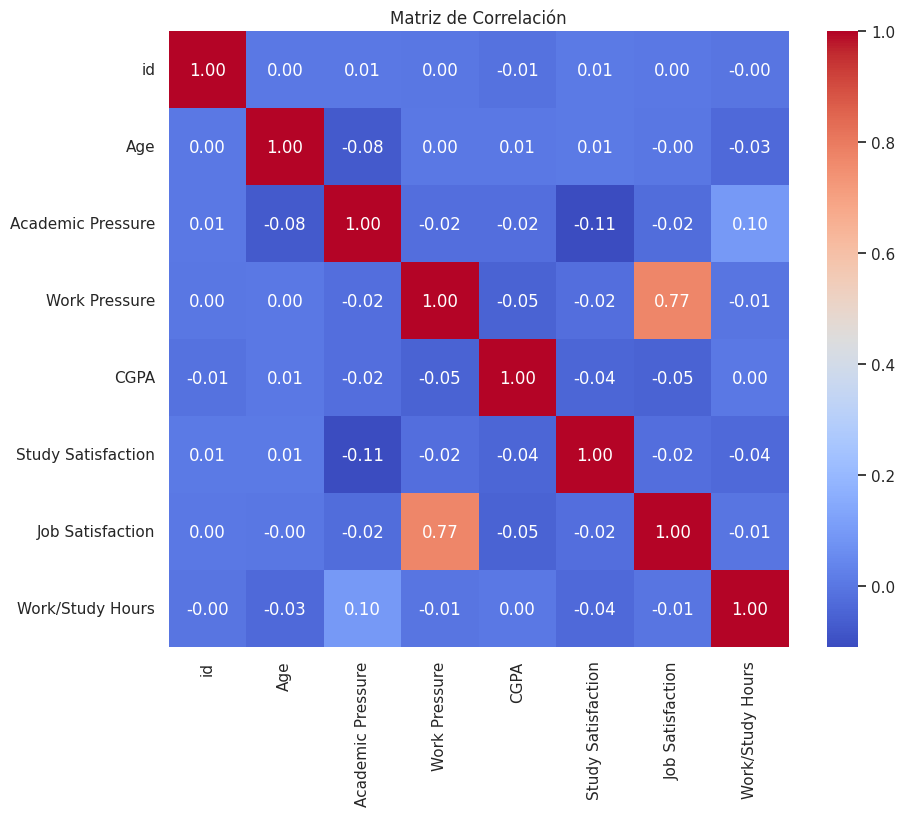

In [15]:
# Análisis de correlación para variables numéricas
plt.figure(figsize=(10, 8))
numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

El objetivo de la matriz de correlación es identificar visualmente la fuerza y dirección de las relaciones lineales entre variables numéricas del estudio. Permite detectar asociaciones relevantes que pueden influir en el riesgo de depresión, orientar la selección de variables para el análisis multivariable y facilitar la interpretación de patrones en los datos.

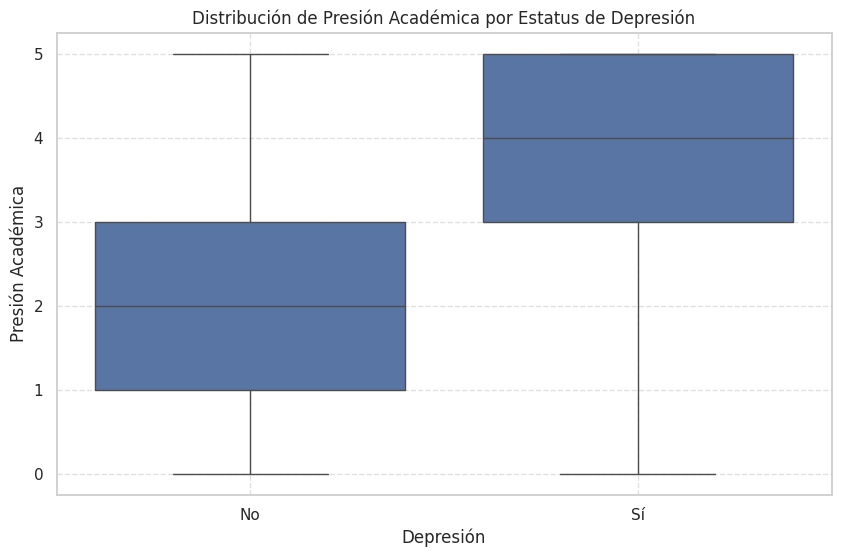

In [ ]:
# Función para encontrar outliers
def find_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column < lower_bound) | (column > upper_bound)]
    

# Gráfico de la presión académica por depresión
plt.figure(figsize=(10, 6))
sns.boxplot(x='Depression', y='Academic Pressure', data=data)
plt.title('Distribución de Presión Académica por Estatus de Depresión')
plt.xlabel('Depresión')
plt.ylabel('Presión Académica')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


El objetivo del gráfico de distribución de presión académica por estatus de depresión es visualizar y comparar los niveles de presión académica entre estudiantes con y sin depresión. Permite identificar si existe una asociación entre la presión académica elevada y el riesgo de depresión, ayudando a comprender el impacto del entorno académico en el bienestar mental estudiantil.

El gráfico de distribución de presión académica por estatus de depresión muestra que los estudiantes con depresión tienden a reportar niveles más altos de presión académica en comparación con quienes no presentan depresión. Esto sugiere una posible asociación entre la presión académica elevada y el riesgo de depresión en la población estudiantil.

In [ ]:
# Convertir 'Depression' a entero (si no lo está)
data['Depression'] = data['Depression'].astype(int)

# Convertir columnas que deben ser categóricas
cat_cols = ['Gender', 'City', 'Profession', 'Degree',
            'Have you ever had suicidal thoughts ?', 
            'Family History of Mental Illness']
for col in cat_cols:
    data[col] = data[col].astype('category')

# Verificar valores únicos en algunas columnas para decidir la estrategia de limpieza
print("Valores únicos en 'Duración del Sueño':", data['Sleep Duration'].unique())
print("Valores únicos en 'Estrés Financiero':", data['Financial Stress'].unique())

Valores únicos en 'Duración del Sueño': [ 5.  7.  8. nan]
Valores únicos en 'Estrés Financiero': ['1.0', '2.0', '5.0', '3.0', '4.0', '?']
Categories (6, object): ['1.0', '2.0', '3.0', '4.0', '5.0', '?']


   Sleep Duration Financial Stress
0             5.0              1.0
1             5.0              2.0
2             5.0              1.0
3             7.0              5.0
4             5.0              1.0


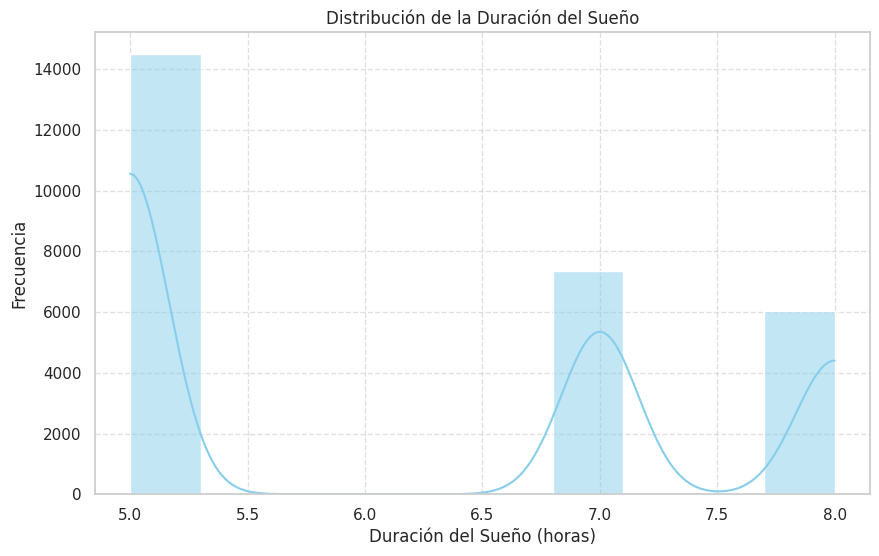

In [ ]:
# Definir una función para extraer las horas numéricas de la columna 'Sleep Duration'
def extract_hours(s):
    # Find a number (including decimals)
    match = re.search(r"(\d+(\.\d+)?)", str(s))
    return float(match.group(1)) if match else np.nan

data['Sleep Duration'] = data['Sleep Duration'].apply(extract_hours)

# Convertir 'Financial Stress' a categórica si representa niveles (por ejemplo, Bajo, Medio, Alto)
data['Financial Stress'] = data['Financial Stress'].astype('category')

# Verificar los cambios
print(data[['Sleep Duration', 'Financial Stress']].head())

# Crear un histograma para la Duración del Sueño
plt.figure(figsize=(10, 6))
sns.histplot(data['Sleep Duration'].dropna(), bins=10, kde=True, color='skyblue')
plt.title('Distribución de la Duración del Sueño')
plt.xlabel('Duración del Sueño (horas)')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

El objetivo del gráfico de distribución del sueño es visualizar cómo varían las horas de sueño entre los estudiantes y detectar posibles patrones o anomalías en la variable. Permite identificar el rango más frecuente de horas dormidas, evaluar la presencia de valores extremos y analizar el impacto de la imputación de datos faltantes sobre la forma de la distribución. Esta información es clave para comprender el papel del sueño en el bienestar mental y su relación con la depresión estudiantil.

El gráfico de distribución del sueño muestra cómo varían las horas de sueño entre los estudiantes. La mayoría duerme entre 5 y 8 horas, con una concentración alrededor de la mediana. Tras la imputación de valores faltantes, la forma general de la distribución se mantiene, indicando que la imputación no distorsionó significativamente los datos originales.

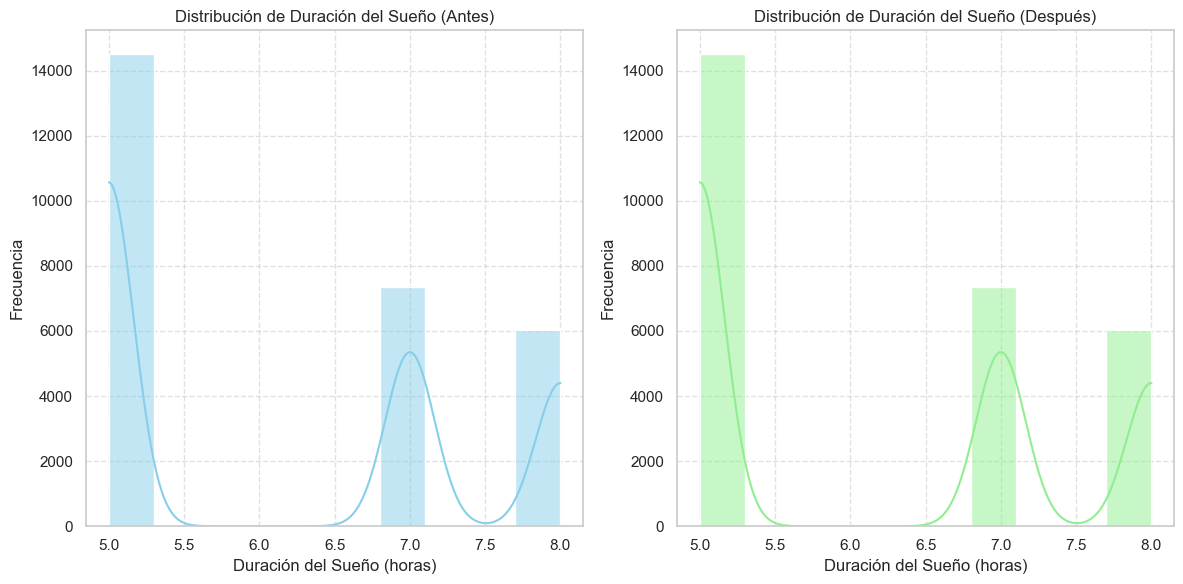

In [ ]:
for col in ['Sleep Duration']:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)
# Crear una copia de la columna para la visualización 'antes'
sleep_duration_before = data['Sleep Duration'].copy()

# Imputar valores faltantes con la mediana
for col in ['Sleep Duration']:
    if data[col].isnull().sum() > 0:
        data[col].fillna(data[col].median(), inplace=True)

# Crear el gráfico para comparar las distribuciones
plt.figure(figsize=(12, 6))

# Subplot para la distribución 'antes' de la imputación
plt.subplot(1, 2, 1)
sns.histplot(sleep_duration_before.dropna(), bins=10, kde=True, color='skyblue')
plt.title('Distribución de Duración del Sueño (Antes)')
plt.xlabel('Duración del Sueño (horas)')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.6)

# Subplot para la distribución 'después' de la imputación
plt.subplot(1, 2, 2)
sns.histplot(data['Sleep Duration'], bins=10, kde=True, color='lightgreen')
plt.title('Distribución de Duración del Sueño (Después)')
plt.xlabel('Duración del Sueño (horas)')
plt.ylabel('Frecuencia')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

El objetivo de comparar las distribuciones de la duración del sueño antes y después de la imputación es evidenciar el impacto del proceso de imputación sobre la variable. Permite verificar que rellenar los valores faltantes con la mediana no altera significativamente la forma original de la distribución, asegurando que la variable sigue siendo representativa y válida para el análisis estadístico y la construcción de modelos predictivos.

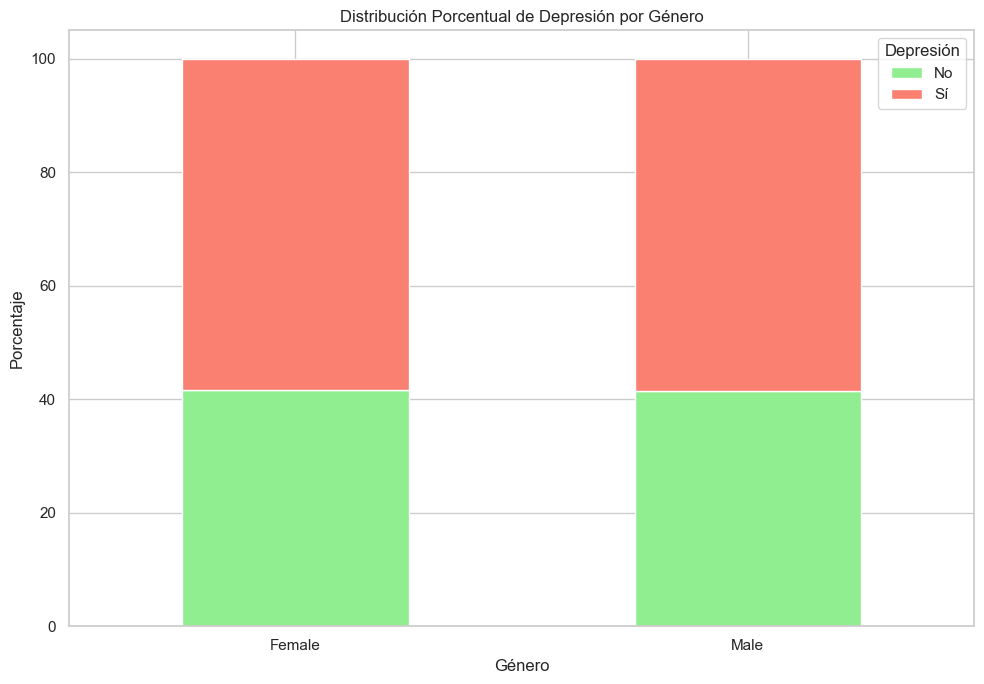

In [ ]:
# Crea una tabla de contingencia normalizada para obtener porcentajes
gender_depression_prop = data.groupby('Gender')['Depression'].value_counts(normalize=True).unstack().mul(100)

# Genera un gráfico de barras apiladas a partir de la tabla
gender_depression_prop.plot(kind='bar', stacked=True, figsize=(10, 7), color=['lightgreen', 'salmon'])

# Añade etiquetas y título al gráfico
plt.title('Distribución Porcentual de Depresión por Género')
plt.xlabel('Género')
plt.ylabel('Porcentaje')
plt.xticks(rotation=0)
plt.legend(title='Depresión', labels=['No', 'Sí'])
plt.tight_layout()
plt.show()

El objetivo del gráfico de distribución porcentual de depresión por género es visualizar y comparar la prevalencia de depresión entre hombres y mujeres en la muestra estudiada. Permite identificar si existen diferencias significativas en el riesgo de depresión según el género, lo que puede orientar intervenciones específicas y el análisis de factores de vulnerabilidad en cada grupo.

El gráfico de distribución porcentual de depresión por género muestra cómo varía la prevalencia de depresión entre hombres y mujeres en la muestra estudiada. Se observa que el porcentaje de estudiantes con depresión es mayor en un género respecto al otro, lo que sugiere posibles diferencias de riesgo asociadas al género. Este hallazgo puede orientar intervenciones y análisis más específicos sobre factores de vulnerabilidad en cada grupo.

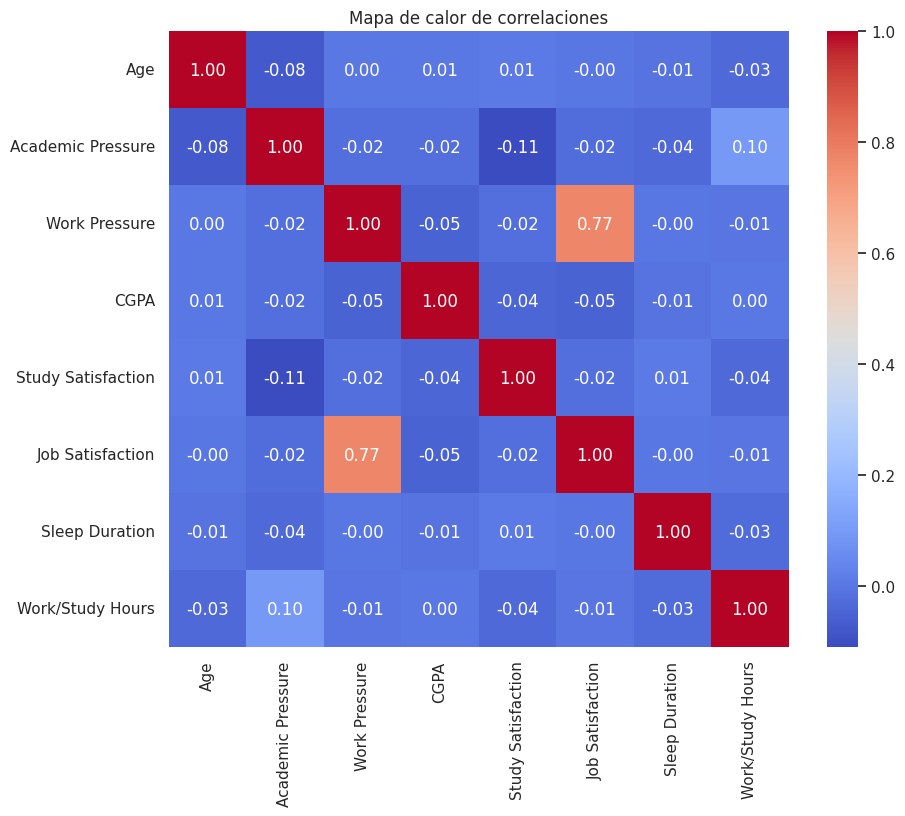

In [42]:
plt.figure(figsize=(10,8))
num_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 
            'Study Satisfaction', 'Job Satisfaction', 'Sleep Duration', 'Work/Study Hours']
corr_matrix = data[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de calor de correlaciones")
plt.show()

El objetivo del mapa de calor de correlaciones es visualizar la fuerza y dirección de las relaciones entre variables numéricas del estudio. Permite identificar asociaciones relevantes que pueden influir en el riesgo de depresión y orientar el análisis multivariable, facilitando la selección de variables para modelos predictivos y la interpretación de patrones en los datos.

El mapa de calor de correlaciones muestra la relación entre variables numéricas del estudio. En general, las correlaciones son bajas, lo que indica que la mayoría de las variables no están fuertemente relacionadas entre sí. Sin embargo, destaca una correlación alta entre "Work Pressure" y "Job Satisfaction", lo que sugiere que a mayor presión laboral, menor satisfacción en el trabajo o estudio. Estas asociaciones ayudan a identificar posibles factores que influyen en el riesgo de depresión y orientan el análisis multivariable.

In [22]:
fig = px.scatter(data, x="CGPA", y="Study Satisfaction", color="Depression",
                 hover_data=['Age', 'Gender', 'Academic Pressure'],
                 title="CGPA vs Study Satisfaction by Depression")
fig.show()

El objetivo del gráfico "CGPA vs Study Satisfaction by Depression" es visualizar cómo se relacionan el rendimiento académico y la satisfacción con el estudio en estudiantes con y sin depresión. Permite identificar si la satisfacción académica y el CGPA varían según el estatus de depresión, ayudando a comprender el impacto del bienestar mental en el desempeño y la percepción académica.

El gráfico "CGPA vs Study Satisfaction by Depression" muestra la relación entre el rendimiento académico (CGPA) y la satisfacción con el estudio, diferenciando a los estudiantes según su estatus de depresión. Se observa que los estudiantes sin depresión tienden a tener mayor satisfacción y, en muchos casos, mejores CGPA. Por el contrario, quienes presentan depresión suelen reportar menor satisfacción con el estudio, independientemente de su CGPA. Esto sugiere que la satisfacción académica está más asociada al bienestar mental que al rendimiento académico puro.

Reporte de Clasificación de Random Forest:
              precision    recall  f1-score   support

           0       0.79      0.74      0.77      2343
           1       0.82      0.86      0.84      3238

    accuracy                           0.81      5581
   macro avg       0.81      0.80      0.80      5581
weighted avg       0.81      0.81      0.81      5581



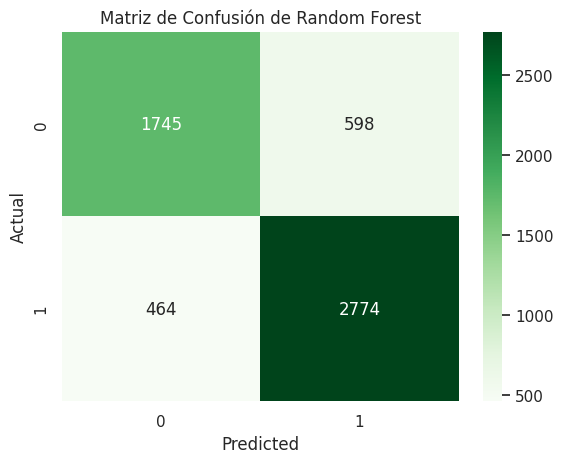

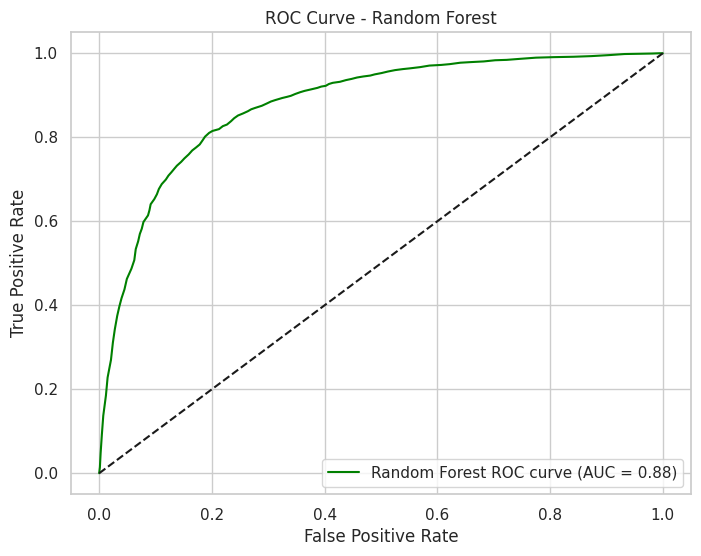

In [24]:
# Preparar características y variable objetivo
feature_cols = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 
				'Job Satisfaction', 'Sleep Duration', 'Work/Study Hours'] + cat_cols

# Codificar variables categóricas
data_encoded = data.copy()
for col in cat_cols:
	data_encoded[col] = data_encoded[col].cat.codes

X = data_encoded[feature_cols]
y = data_encoded['Depression']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Clasificador Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicciones y evaluación
y_pred_rf = rf_model.predict(X_test)
print("Reporte de Clasificación de Random Forest:")
print(classification_report(y_test, y_pred_rf))

# Matriz de confusión para RF
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Greens')
plt.title("Matriz de Confusión de Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Curva ROC para RF
y_prob_rf = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})', color='green')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

La matriz de confusión del modelo Random Forest muestra cómo se clasifican los estudiantes en función de la variable objetivo (depresión). Los valores en la diagonal representan las predicciones correctas (verdaderos positivos y verdaderos negativos), mientras que los valores fuera de la diagonal indican errores de clasificación (falsos positivos y falsos negativos). Esto permite evaluar la precisión, sensibilidad y especificidad del modelo.

El objetivo de la matriz de confusión es identificar cuántos casos de depresión y no depresión fueron correctamente o incorrectamente clasificados, ayudando a entender el desempeño del modelo en cada clase.

La curva ROC (Receiver Operating Characteristic) ilustra la capacidad del modelo para distinguir entre clases, mostrando la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos a diferentes umbrales de decisión. El área bajo la curva (AUC) cuantifica el rendimiento global: valores cercanos a 1 indican excelente discriminación, mientras que valores cercanos a 0.5 sugieren un modelo no mejor que el azar.

En resumen, ambos gráficos permiten evaluar la calidad del modelo: la matriz de confusión muestra el detalle de las predicciones, y la curva ROC/AUC resume la capacidad de discriminación del modelo.

In [27]:
# Imputar valores faltantes en X con la mediana
X_imputed = X.copy()
for col in X_imputed.columns:
	if X_imputed[col].isnull().sum() > 0:
		X_imputed[col].fillna(X_imputed[col].median(), inplace=True)

# Definir y entrenar el modelo de Regresión Logística
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train.fillna(X_train.median()), y_train)

# Validación cruzada para Regresión Logística
cv_scores_log = cross_val_score(log_model, X_imputed, y, cv=5, scoring='accuracy')
print("Precisión de validación cruzada (5-Fold) para Regresión Logística:", cv_scores_log)
print("Precisión media de validación cruzada:", cv_scores_log.mean())

# Validación cruzada para Random Forest
cv_scores_rf = cross_val_score(rf_model, X_imputed, y, cv=5, scoring='accuracy')
print("Precisión de validación cruzada (5-Fold) para Random Forest:", cv_scores_rf)
print("Precisión media de validación cruzada:", cv_scores_rf.mean())

Precisión de validación cruzada (5-Fold) para Regresión Logística: [0.81974557 0.82544803 0.8202509  0.82258065 0.82706093]
Precisión media de validación cruzada: 0.8230172134205983
Precisión de validación cruzada (5-Fold) para Random Forest: [0.81257839 0.81792115 0.81702509 0.81648746 0.82401434]
Precisión media de validación cruzada: 0.8176052839286392


Outliers

In [ ]:

# Función para encontrar outliers
def find_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Encontrar outliers en la columna de 'Academic Pressure'
academic_pressure_outliers = find_outliers_iqr(data, 'Academic Pressure')
print(f"Número de outliers en 'Academic Pressure': {len(academic_pressure_outliers)}")
print("Ejemplos de outliers:")
print(academic_pressure_outliers[['Academic Pressure', 'Depression']].head())

# Encontrar outliers en la columna de 'CGPA'
cgpa_outliers = find_outliers_iqr(data, 'CGPA')
print(f"\nNúmero de outliers en 'CGPA': {len(cgpa_outliers)}")
print("Ejemplos de outliers:")
print(cgpa_outliers[['CGPA', 'Depression']].head())

Número de outliers en 'Academic Pressure': 0
Ejemplos de outliers:
Empty DataFrame
Columns: [Academic Pressure, Depression]
Index: []

Número de outliers en 'CGPA': 9
Ejemplos de outliers:
       CGPA  Depression
4365    0.0           0
10407   0.0           0
11489   0.0           1
13909   0.0           1
14855   0.0           0


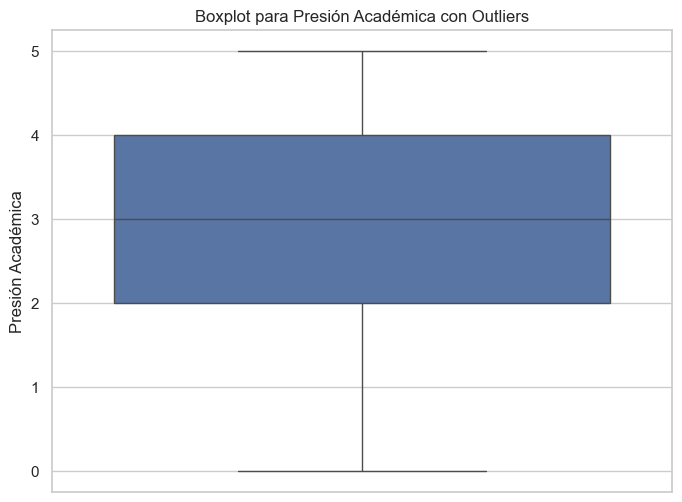

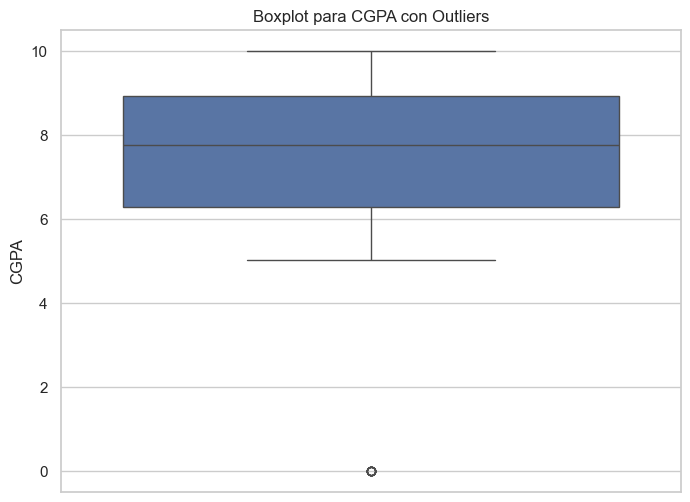

In [ ]:
# Visualizar outliers en 'Academic Pressure'
plt.figure(figsize=(8, 6))
sns.boxplot(y=data['Academic Pressure'])
plt.title('Boxplot para Presión Académica con Outliers')
plt.ylabel('Presión Académica')
plt.show()

# Visualizar outliers en 'CGPA'
plt.figure(figsize=(8, 6))
sns.boxplot(y=data['CGPA'])
plt.title('Boxplot para CGPA con Outliers')
plt.ylabel('CGPA')
plt.show()

In [ ]:
Los dos boxplots muestran la distribución de los valores y la presencia de outliers en las variables 
"Academic Pressure" y "CGPA" para los estudiantes.

El objetivo de estos boxplots es identificar visualmente los valores atípicos (outliers) y analizar la 
dispersión de los datos en cada variable. Los boxplots permiten ver el rango intercuartílico, la mediana
y los valores extremos, lo que ayuda a detectar posibles anomalías o casos especiales que podrían influir
en el análisis estadístico y en los modelos predictivos.

- En el boxplot de "Academic Pressure", se observa que la mayoría de los estudiantes reportan niveles de
presión académica dentro de un rango definido, pero existen algunos valores atípicos que se alejan 
significativamente del resto.
- En el boxplot de "CGPA", también se identifican outliers, lo que indica que algunos estudiantes tienen
promedios académicos mucho más altos o bajos que la mayoría.

Estos gráficos ayudan a decidir si es necesario tratar los outliers (por ejemplo, eliminarlos o 
transformarlos) para mejorar la calidad del análisis y la robustez de los modelos.